Warren & Dye (2003) で提案されたSemi-Linear Inversion (SLI)を実装し、簡単なケースで有効性をテストする。

# import

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib.patches import Ellipse
from matplotlib.offsetbox import AnchoredOffsetbox, AuxTransformBox
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import importlib
from scipy.signal import fftconvolve
np.random.seed(42)  

# pygravlensをimportするために、パスを通す
import sys
sys.path.append('/home/tsujtaak/atsujita/HATLASJ0900/kinematics/pygravlens')   
import pygravlens
importlib.reload(pygravlens)
import pygravlens as gl

# Mock simulation

number of planes: 1
maingrid: [[-2.5, 2.5, 20], [-2.5, 2.5, 20]]
galgrid: [1e-06, 2.5, 20, 20]


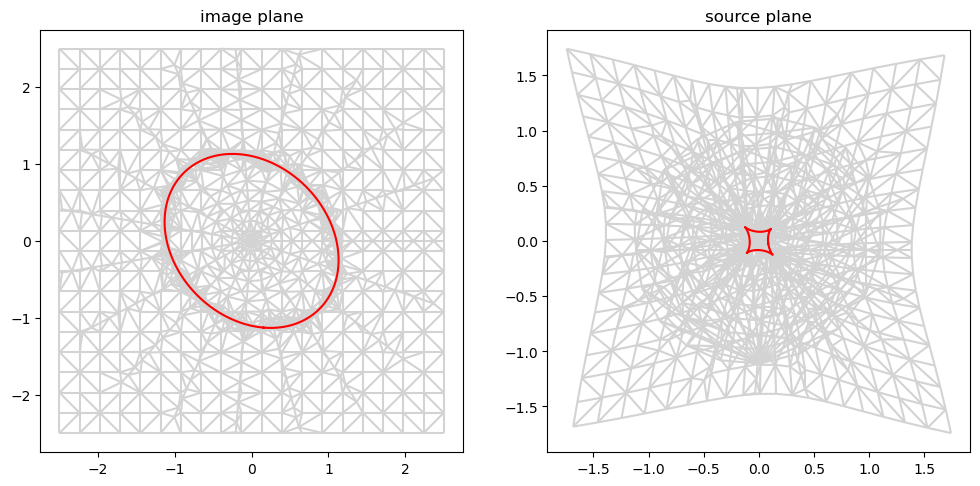

In [41]:
plane = gl.lensplane('ellpow', [0.0, 0.0, 1.0, 1, 0.2, -45])
model = gl.lensmodel([plane])
model.info()
model.tile()
model.plot(plotgrid=True,plotcrit='red')

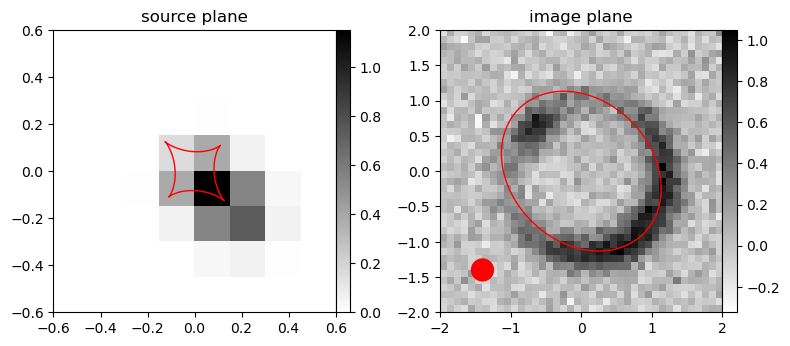

In [42]:
# --- Hyper parameters --- #
pix_size_i = 0.1  # pixel size of image plane in arcsec
pix_size_s = 0.15  # pixel size of source plane in arcsec

xy_min_i, xy_max_i = -2, 2  # x- and y-axis limits of image plane in arcsec
xy_min_s, xy_max_s = -0.6, 0.6  # x- and y-axis limits of source plane in arcsec

npix_i = int((xy_max_i - xy_min_i) / pix_size_i)  # number of pixels in each axis
npix_s = int((xy_max_s - xy_min_s) / pix_size_s)  # number of pixels in each axis

psf_size = 0.3  # pixel size of PSF in arcsec
rms = 0.1  # mock noise in arbitrary units


# --- Source parameters --- #
srcmode = 'gaus'
# srcarr = list of [u0,v0,radius,intensity]
srcarr = [[0.05, -0.05, 0.1, 1],
          [0.2, -0.2, 0.1, 1]]


# --- lensing --- #
srcmap,imgmap = model.extendedimg(srcmode=srcmode, srcarr=srcarr, extent_img=[[xy_min_i, xy_max_i, npix_i],[xy_min_i, xy_max_i, npix_i]], extent_src=[[xy_min_s, xy_max_s, npix_s],[xy_min_s, xy_max_s, npix_s]])


# --- caustics and critical curve --- #
crit, caus = model.plotcrit(plot=False)


# --- beam convolution --- #
def make_gaussian_psf(fwhm_arcsec, pixscale_arcsec, nsigma=4.0):
    """
    ガウシアンPSFカーネル（単位積分）を返す。
    fwhm_arcsec : ビームFWHM[arcsec]
    pixscale_arcsec : 画像面ピクセルスケール[arcsec/pix]
    nsigma : カーネル半径(σの何倍まで切るか)
    """
    sigma_pix = (fwhm_arcsec / (2.0 * np.sqrt(2.0 * np.log(2.0)))) / pixscale_arcsec
    half = int(np.ceil(nsigma * sigma_pix))
    ax = np.arange(-half, half + 1, dtype=float)
    X, Y = np.meshgrid(ax, ax)
    psf = np.exp(-(X**2 + Y**2) / (2.0 * sigma_pix**2))
    psf /= psf.sum()  # 正規化（フラックス保存）
    return psf

psf = make_gaussian_psf(psf_size, pix_size_i, nsigma=4.0)
imgmap = fftconvolve(imgmap, psf, mode='same')  # 画像面にPSFを畳み込み


# --- add mock noise --- #
noisemap = np.random.normal(0, rms, imgmap.shape)
imgmap += noisemap


# --- plot --- #
cmap = 'gray_r'
f, ax = plt.subplots(1, 2, figsize=(8, 4))
im0 = ax[0].imshow(srcmap, origin='lower', extent=[xy_min_s, xy_max_s, xy_min_s, xy_max_s], cmap=cmap)
ax[0].set_title('source plane')
im1 = ax[1].imshow(imgmap, origin='lower', extent=[xy_min_i, xy_max_i, xy_min_i, xy_max_i], cmap=cmap)
ax[1].set_title('image plane')

# psfサイズをimage planeの左下に楕円として表示
xy_beam = (xy_min_i + 2*psf_size, xy_min_i + 2*psf_size)
ellipse = Ellipse(xy=xy_beam, width=psf_size, height=psf_size, edgecolor='red', facecolor='red', lw=1.5)
ax[1].add_patch(ellipse)

# caustics and critical curve
ax[0].plot(caus[0][:,0], caus[0][:,1], 'r-', lw=1., label='caustics')
ax[1].plot(crit[0][:,0], crit[0][:,1], 'r-', lw=1., label='critical curve')


# colorbarを追加
im = [im0, im1]
for i in range(2):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.0)
    cbar = f.colorbar(im[i], cax=cax)
plt.tight_layout()

In [43]:
imgmap.shape, psf_size/pix_size_i

((40, 40), 2.9999999999999996)

# Semi-Linear Inversion

## データ準備

In [44]:
# --- グリッド（すでに extents から復元可能） ---
xlo_i, xhi_i, nx_i = xy_min_i, xy_max_i, npix_i
ylo_i, yhi_i, ny_i = xy_min_i, xy_max_i, npix_i
xi = np.linspace(xlo_i, xhi_i, nx_i)
yi = np.linspace(ylo_i, yhi_i, ny_i)

xlo_s, xhi_s, nx_s = xy_min_s, xy_max_s, npix_s
ylo_s, yhi_s, ny_s = xy_min_s, xy_max_s, npix_s
xs = np.linspace(xlo_s, xhi_s, nx_s)
ys = np.linspace(ylo_s, yhi_s, ny_s)

# --- 画像面の規則格子を作ってレンズ方程式でソース座標へ ---
XX, YY = np.meshgrid(xi, yi)                         # (ny_i,nx_i)
ximg = np.stack([XX, YY], axis=-1)                   # (ny_i,nx_i,2)
uarr, Aarr, tarr = model.lenseqn(ximg)               # (ny_i,nx_i,2)

# --- 後で便利な辞書にまとめる ---
pack = dict(
    xi=xi, yi=yi, xs=xs, ys=ys,
    d_obs=imgmap.copy(),              # 観測像 (PSF+noise入り)
    sigma_map=np.full_like(imgmap, rms),
    psf=psf,
    uarr=uarr,
    src_true=srcmap.copy(),
    extent_img=[[xlo_i,xhi_i,nx_i],[ylo_i,yhi_i,ny_i]],
    extent_src=[[xlo_s,xhi_s,nx_s],[ylo_s,yhi_s,ny_s]]
)

In [45]:
ximg[0,1]

array([-1.8974359, -2.       ])

## Lensing operator

In [46]:
from scipy.sparse import csr_matrix

def build_L_from_uarr(uarr, extent_src):
    # extent_src の取り出し
    (xlo_s, xhi_s, nx_s), (ylo_s, yhi_s, ny_s) = extent_src
    ny_i, nx_i = uarr.shape[:2]
    J = ny_i * nx_i
    I = ny_s * nx_s

    # ソース画素ピッチ（linspace端点含む想定）
    dx = (xhi_s - xlo_s) / (nx_s - 1) if nx_s > 1 else 1.0
    dy = (yhi_s - ylo_s) / (ny_s - 1) if ny_s > 1 else 1.0

    # 連続→格子添字（浮動小数）
    fx = (uarr[..., 0] - xlo_s) / dx
    fy = (uarr[..., 1] - ylo_s) / dy
    ix = np.floor(fx).astype(np.int64);  wx = fx - ix
    iy = np.floor(fy).astype(np.int64);  wy = fy - iy

    rows_list, cols_list, vals_list = [], [], []
    jj = np.arange(J, dtype=np.int64)  # 行インデックス（画像側, 0..J-1）

    # 4隅（双一次）
    for ox, wxc in ((0, 1.0-wx), (1, wx)):  # offset, weight coefficient
        for oy, wyc in ((0, 1.0-wy), (1, wy)):
            cx = ix + ox  # 実際に参照するsource pixelの整数インデックス
            cy = iy + oy
            w  = (wxc * wyc).ravel()          # (J,)
            # ソース範囲内だけ採用
            mask = ((cx>=0) & (cx<nx_s) & (cy>=0) & (cy<ny_s)).ravel()  # ← 1次元に揃える
            if not np.any(mask): # 別になくても良いが、無駄な計算を避けるため
                continue
            cols = (cy*nx_s + cx).ravel()[mask]     # (J_valid,)
            rows = jj[mask]                         # (J_valid,)
            vals = w[mask]                          # (J_valid,)

            rows_list.append(rows)
            cols_list.append(cols)
            vals_list.append(vals)

    if len(rows_list) == 0:
        # 全て範囲外（グリッドが小さ過ぎ or uarrが外に出ている）
        return csr_matrix((J, I), dtype=float)

    # 4つのリストを連結してCSR行列を作成
    rows = np.concatenate(rows_list)
    cols = np.concatenate(cols_list)
    vals = np.concatenate(vals_list)

    L = csr_matrix((vals, (rows, cols)), shape=(J, I))
    return L

L = build_L_from_uarr(pack["uarr"], pack["extent_src"])

## PSF convolution

In [47]:
from scipy.sparse.linalg import LinearOperator
from scipy.signal import fftconvolve

ny_i, nx_i = pack["d_obs"].shape
psf = pack["psf"]

def make_P_operator(psf, ny, nx, mode='same'):
    J = ny*nx
    def mv(x):
        img = x.reshape(ny, nx)
        y = fftconvolve(img, psf, mode=mode)
        return y.ravel()
    # 対称PSFなら P^T=P でOK
    return LinearOperator((J, J), matvec=mv, rmatvec=mv, dtype=float)

P = make_P_operator(psf, ny_i, nx_i)

## Mask

## Solve!
- ただし、実際に巨大な行列の逆行列は計算できないので、数値的に解く

In [48]:
from scipy.sparse.linalg import lsqr # 疎行列扱える

d = pack["d_obs"].ravel()
W12 = 1.0/np.maximum(pack["sigma_map"].ravel(), 1e-12)

def Amv(s):
    return W12 * P.matvec(L @ s)
def ATmv(y):
    return L.T @ P.rmatvec(W12 * y)

J, I = L.shape
Aop = LinearOperator((J, I), matvec=Amv, rmatvec=ATmv, dtype=float)
b = W12 * d

atol = 1e-10 # 収束判定用の絶対許容誤差 ||Ax - b|| < atol ||A|| * ||x||
btol = 1e-10 # 収束判定用の相対許容誤差 ||Ax - b|| / ||b|| < btol
iter_lim = 2000  # 最大反復回数
ls = lsqr(Aop, b, atol=atol, btol=btol, iter_lim=iter_lim)
s_hat = ls[0].reshape(ny_s, nx_s)   # 復元ソース

/tmp/ipykernel_1796731/1933563194.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 1600x400 with 5 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)
/tmp/ipykernel_1796731/1933563194.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 1600x400 with 6 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)
/tmp/ipykernel_1796731/1933563194.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 1600x400 with 7 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)
/tmp/ipykernel_1796731/1933563194.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 1600x400 with 8 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)


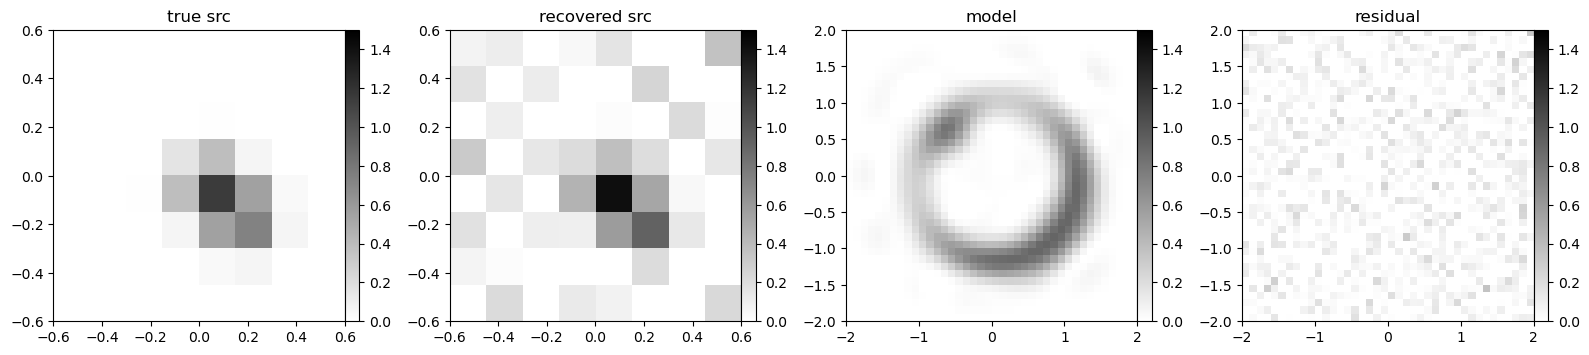

In [49]:
# 予測像を作って観測と比較
model_img = P.matvec((L @ s_hat.ravel())).reshape(ny_i, nx_i)
resid = (pack["d_obs"] - model_img)

fig,ax = plt.subplots(1,4,figsize=(16,4))
im0 = ax[0].imshow(pack["src_true"], origin='lower', extent=[xy_min_s,xy_max_s,xy_min_s,xy_max_s], cmap='gray_r', vmin=0, vmax=1.5); ax[0].set_title('true src')
im1 = ax[1].imshow(s_hat,         origin='lower', extent=[xy_min_s,xy_max_s,xy_min_s,xy_max_s], cmap='gray_r', vmin=0, vmax=1.5); ax[1].set_title('recovered src')
im2 = ax[2].imshow(model_img,    origin='lower', extent=[xy_min_i,xy_max_i,xy_min_i,xy_max_i], cmap='gray_r', vmin=0, vmax=1.5); ax[2].set_title('model')
im3 = ax[3].imshow(resid,    origin='lower', extent=[xy_min_i,xy_max_i,xy_min_i,xy_max_i], cmap='gray_r', vmin=0, vmax=1.5); ax[3].set_title('residual')

# colorbarを追加
im = [im0, im1, im2, im3]
for i in range(4):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.0)
    cbar = f.colorbar(im[i], cax=cax)
plt.tight_layout()

## Covariance matrix

In [50]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator, cg

W = diags(1.0 / np.maximum(pack["sigma_map"].ravel(), 1e-12))   # J×J 対角
J, I = L.shape                                          # L: J×I（CSR想定）

def F_matvec(s_vec):
    # s_vec: (I,)  -> F s = L^T P^T W P L s
    tmp = L @ s_vec                      # (J,)
    tmp = P.matvec(tmp)                  # (J,)
    tmp = W @ tmp                        # (J,)
    tmp = P.rmatvec(tmp)                 # (J,)   （PSFが対称なら matvec と同じ）
    return L.T @ tmp                     # (I,)

Fop = LinearOperator((I, I), matvec=F_matvec, dtype=float)

In [51]:
rng = np.random.default_rng(0)
M = 32                   # 10–50 程度でだいたい良い（必要精度で調整）
diagC = np.zeros(I)

for _ in range(M):
    z = rng.choice([-1.0, 1.0], size=I)             # Rademacher
    x, info = cg(Fop, z, atol=1e-8, rtol=1e-8, maxiter=2000)  # 対称正定値なのでCG
    # 収束チェック（info==0で収束）
    if info != 0:
        # 収束が甘い/特異なら微小リッジを足すと安定：F -> F + λI
        pass
    diagC += z * x

diagC /= M
sigma_src = np.sqrt(np.maximum(diagC, 0.0)).reshape(ny_s, nx_s)  # 1σマップ

/tmp/ipykernel_1796731/4118334384.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1600x800 with 9 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)
/tmp/ipykernel_1796731/4118334384.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1600x800 with 10 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)
/tmp/ipykernel_1796731/4118334384.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1600x800 with 11 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)
/tmp/ipykernel_1796731/4118334384.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1600x800 with 12 Axes> than <Figure size 800x400 with 4 Axes> which fig.colorbar is called on.
  cbar = f.colorbar(im[i], cax=cax)
/tmp/ipykernel_1796731/4118334384.py:22: UserWarning: Add

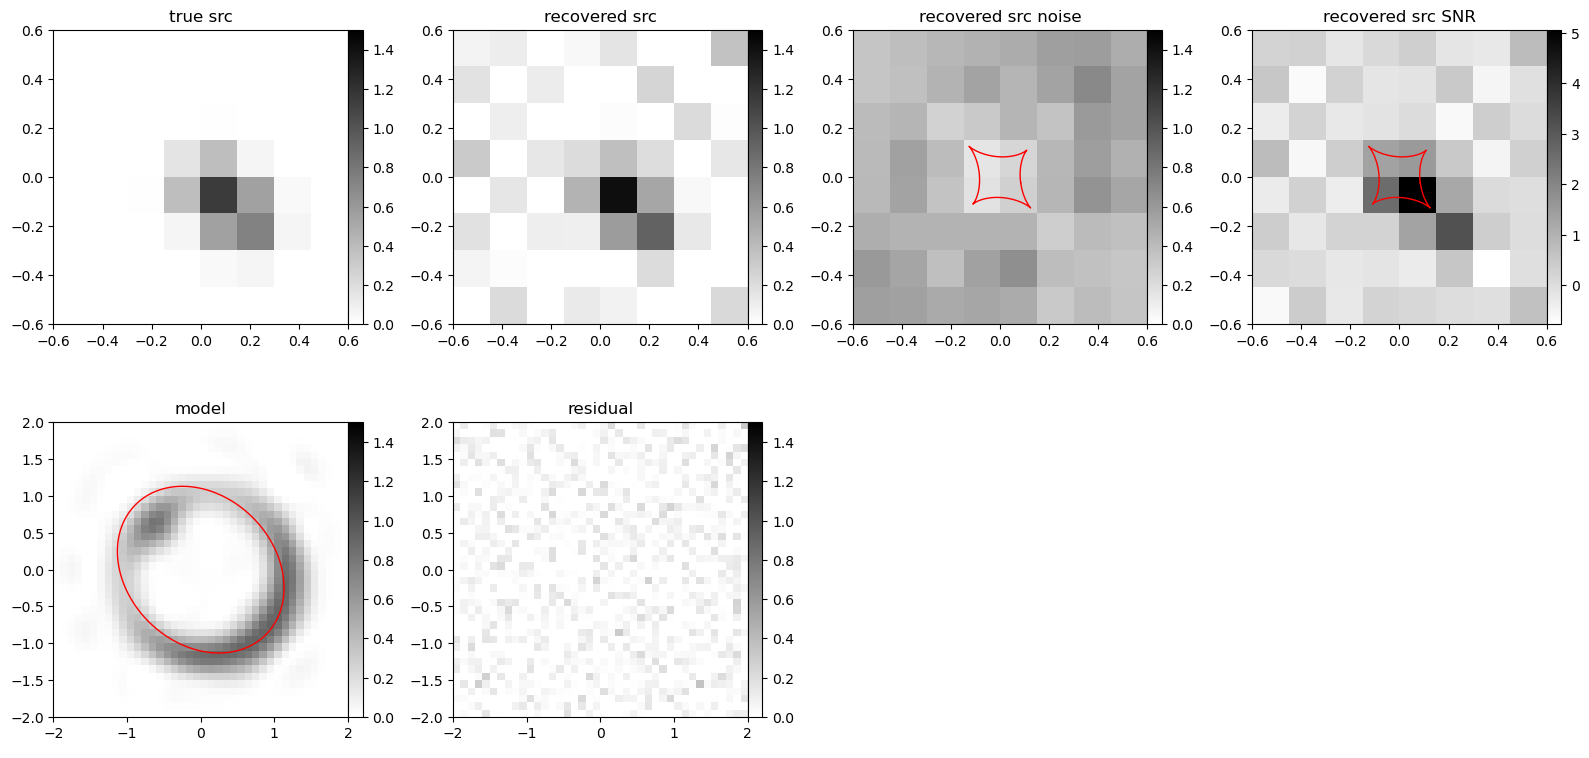

In [54]:
fig,ax = plt.subplots(2,4,figsize=(16,8))
ax = ax.flatten()
im0 = ax[0].imshow(pack["src_true"], origin='lower', extent=[xy_min_s,xy_max_s,xy_min_s,xy_max_s], cmap='gray_r', vmin=0, vmax=1.5); ax[0].set_title('true src')
im1 = ax[1].imshow(s_hat,         origin='lower', extent=[xy_min_s,xy_max_s,xy_min_s,xy_max_s], cmap='gray_r', vmin=0, vmax=1.5); ax[1].set_title('recovered src')
im2 = ax[2].imshow(sigma_src,         origin='lower', extent=[xy_min_s,xy_max_s,xy_min_s,xy_max_s], cmap='gray_r', vmin=0, vmax=1.5); ax[2].set_title('recovered src noise')
im3 = ax[3].imshow(s_hat/sigma_src,         origin='lower', extent=[xy_min_s,xy_max_s,xy_min_s,xy_max_s], cmap='gray_r'); ax[3].set_title('recovered src SNR')
im4 = ax[4].imshow(model_img,    origin='lower', extent=[xy_min_i,xy_max_i,xy_min_i,xy_max_i], cmap='gray_r', vmin=0, vmax=1.5); ax[4].set_title('model')
im5 = ax[5].imshow(resid,    origin='lower', extent=[xy_min_i,xy_max_i,xy_min_i,xy_max_i], cmap='gray_r', vmin=0, vmax=1.5); ax[5].set_title('residual')

crit, caus = model.plotcrit(plot=False)
ax[2].plot(caus[0][:,0], caus[0][:,1], 'r-', lw=1., label='caustics')
ax[3].plot(caus[0][:,0], caus[0][:,1], 'r-', lw=1., label='caustics')
ax[4].plot(crit[0][:,0], crit[0][:,1], 'r-', lw=1., label='critical curve')
ax[6].axis('off')  # 空のサブプロットを非表示にする
ax[7].axis('off')  # 空のサブプロットを非表示にする

# colorbarを追加
im = [im0, im1, im2, im3, im4, im5]
for i in range(6):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.0)
    cbar = f.colorbar(im[i], cax=cax)
plt.tight_layout()

'まとめの教訓\n- sourceがちゃんと収まるように!\n- pixel sizeは十分小さく!\n'

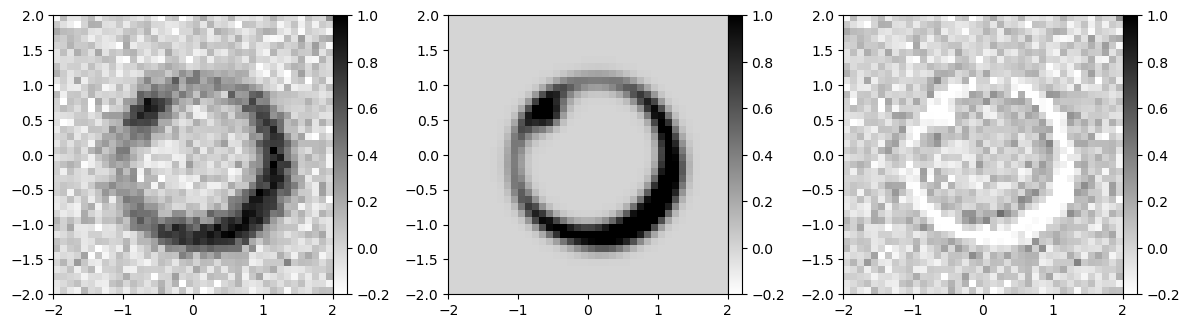

In [14]:
# extendedimgとextendedimg_pixの生合成チェック
img_pix = model.extendedimg_pix(srcarr=srcmap, extent_img=[[xy_min_i, xy_max_i, npix_i], [xy_min_i, xy_max_i, npix_i]], extent_src=[[xy_min_s, xy_max_s, npix_s], [xy_min_s, xy_max_s, npix_s]], Dsnew=None, order=3, mode='constant', cval=0.0)
# img_pix += np.random.normal(0, rms, img_pix.shape)

f, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].imshow(imgmap, origin='lower', extent=[xy_min_i, xy_max_i, xy_min_i, xy_max_i], cmap=cmap, vmin=-0.2, vmax=1)
im1 = ax[1].imshow(img_pix, origin='lower', extent=[xy_min_i, xy_max_i, xy_min_i, xy_max_i], cmap=cmap, vmin=-0.2, vmax=1)
im2 = ax[2].imshow(imgmap-img_pix, origin='lower', extent=[xy_min_i, xy_max_i, xy_min_i, xy_max_i], cmap=cmap, vmin=-0.2, vmax=1)

# colorbarを追加
im = [im0, im1, im2]
for i in range(3):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.0)
    cbar = f.colorbar(im[i], cax=cax)
plt.tight_layout()

"""まとめの教訓
- sourceがちゃんと収まるように!
- pixel sizeは十分小さく!
"""

In [15]:
def mygrid(xarr,yarr):
    return np.moveaxis(np.array(np.meshgrid(xarr,yarr)),0,-1)

In [16]:
xarr = [0, 1, 2]
yarr = [0, 10, 20]
grid = mygrid(xarr, yarr)

In [17]:
grid

array([[[ 0,  0],
        [ 1,  0],
        [ 2,  0]],

       [[ 0, 10],
        [ 1, 10],
        [ 2, 10]],

       [[ 0, 20],
        [ 1, 20],
        [ 2, 20]]])

In [18]:
grid[0, 1]

array([1, 0])

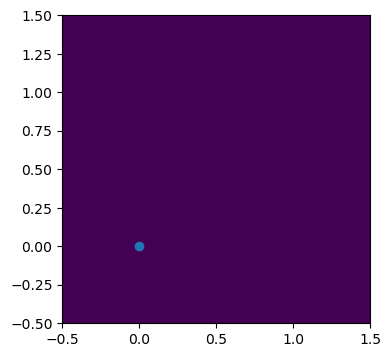

In [19]:
# pythonにおける座標の定義
# fitsのheaderのCRPIXとかCRVALもピクセル中心で定義されている（ただし1-index）。
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(np.zeros((2,2)), origin="lower")
ax.scatter(0, 0)